This is a Python Notebook for  the Titanic Survival Challenge were the objective will not be only to develop a model, will also be analyze the features and compare a variety of models that can help to solve this challenge.

This notebook will be divided on the next sections:

 1. Intro 
 2. Data cleaning and Transformation
 3. Data Exploration 
 4. Data Modeling with
     4.1 Decision Tree Model
     4.2 Logistic Regression
     4.3 Support Vector Machine.
 5. Comparation
 6. Conclusion

let's take on count that the predictive models might need different preprocessing steps, so I will use different dataframes if needed

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing libary
from sklearn import preprocessing, svm, tree, linear_model, metrics #methods 
#for machine learning tools like preprocessing, models and metrics
from sklearn.model_selection import train_test_split #replace cross_validation method
import matplotlib.pyplot as plt #plotting library
%matplotlib inline

## Intro 
A first impression

In [2]:
#first let's read the data and take a look
titanic_df = pd.read_csv("train.csv") 
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There 12 features including our target feature (Survived), so now check how is builded our dataset

Take this as a note for embarkation: C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


First, there are three columns with missing data, "Age", "Cabin" and "Embarked". This problem is handled on the next step.
There are five non-numeric columns, we should take a look and then decide how to transform them. Non-numeric data is troublesome so we will handle it on the next step too.

### Cleaning and Transforming Data

Here the first thing is to handle missing data. There are several ways to deal with them, some of them are removing the record, nullify the value (set to null) or impute values. So we must check first the column and how it can affect the target

In [4]:
print("Cabin value count: %d " % titanic_df["Cabin"].count())
print("Age value count: %d" % titanic_df["Age"].count())
print("Embarked value count: %d" % titanic_df["Embarked"].count())

Cabin value count: 204 
Age value count: 714
Embarked value count: 889


Cabin column must be dropped, is amount of missing data is to big that it will affect negatively the model.
For embarked, the value of missing data is very slow, so we can try to imput some value.
Age contains a lot of missing value, but is not so big as Cabin. We could impute the mean age in the missing ages value, but I will use the simplest way: remove the rows (not column) after filling Embarked missing values

In [5]:
titanic_df.drop("Cabin",axis=1,inplace=True)
titanic_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

There is a majority class, which is "S", so we can input "S" for those missing values and proceed to remove the rows with missing values on Age

In [6]:
titanic_df["Embarked"].fillna("S",inplace = True)
titanic_df.dropna(inplace=True)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Embarked       714 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 66.9+ KB


Now that all the columns have the same number of records, let's transform the non-numeric data and drop columns to improve our analysis. We can make some suppositions based on the columns info. By example, "Name" column have the name of the passengers, and it should be very unique, so it can be 714 different names and that doesn't help to generalize a model. The same goes to "Ticket" column.
"PassengerId" is a unique numerical value, but for our goal (predict survival rate) this information doesn't help. Let's check them.

In [7]:
print("Name value count: %d " % titanic_df["Name"].value_counts().size)
print("Ticket value count: %d " % titanic_df["Ticket"].value_counts().size)
print("PassengerId value count: %d " % titanic_df["PassengerId"].value_counts().size)
print("Sex value count: %d " % titanic_df["Sex"].value_counts().size)
print("Embarked value count: %d " % titanic_df["Embarked"].value_counts().size)

Name value count: 714 
Ticket value count: 542 
PassengerId value count: 714 
Sex value count: 2 
Embarked value count: 3 


As previously said, "Name", "Ticket" and "PassengerID" have very unique values, so we should drop them. For "Sex" and "Embarked", let's transform them into numeric values to improve our analysis. Let's save the true label for later too.

In [8]:
titanic_df.drop(["Name","Ticket","PassengerId"],axis=1, inplace=True)
sex_labels= titanic_df["Sex"].unique()
embarked_labels = titanic_df["Embarked"].unique()

In [9]:
le = preprocessing.LabelEncoder()
le.fit(titanic_df.Sex.values)
titanic_df["Sex"] = le.transform(titanic_df.Sex.values)
le.fit(titanic_df.Embarked.values)
titanic_df["Embarked"] = le.transform(titanic_df.Embarked.values)

In [10]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


Now let's start the Data Exploration

### Data Exploration

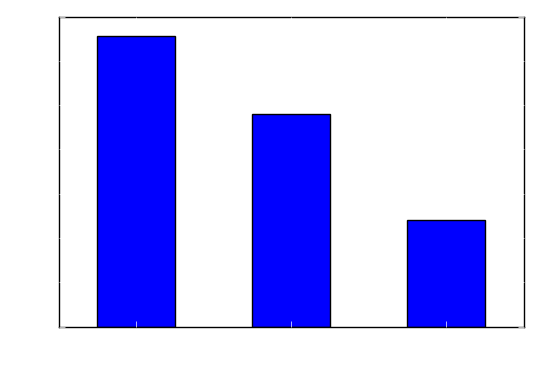

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.set_ylabel("Survival rate")
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
titanic_df.groupby("Pclass").mean()["Survived"].plot.bar()
ax.set_xticklabels(labels = ax.get_xticklabels(),rotation=0)